In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs
import dcor

sys.path.append("fig1_batch")
import importlib
import models
import random
import model_fig1 as model_sim

In [3]:
importlib.reload(model_sim)

<module 'model_fig1' from 'fig1_batch/model_fig1.py'>

In [4]:
device = torch.device("cpu") # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [5]:
PLT_CELL = 2.5

In [6]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [7]:
M = 100
N_vals = [64, 1]
N0 = 64

# setup simulation object
sims_all = [gwot.sim.Simulation(V = model_sim.Psi, dV = model_sim.dPsi, birth_death = False, 
                          N = np.array([N0, ] + [N, ]*(model_sim.T-2) + [N0, ]),
                          T = model_sim.T, 
                          d = model_sim.dim, 
                          D = model_sim.D, 
                          t_final = model_sim.t_final, 
                          ic_func = model_sim.ic_func, 
                          pool = None) for N in N_vals]

# sample from simulation
for s in sims_all:
    s.sample(steps_scale = int(model_sim.sim_steps/s.T));

In [8]:
sim_gt = copy.deepcopy(sims_all[0])
sim_gt.N = np.array([500, ]*model_sim.T)
sim_gt.sample(steps_scale = int(model_sim.sim_steps/sims_all[0].T));

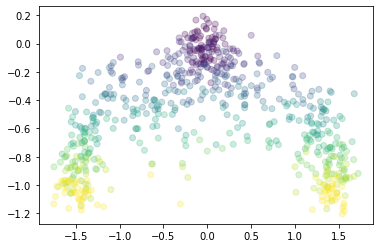

In [9]:
# plot samples
i = 0
plt.scatter(sims_all[i].x[:, 0], sims_all[i].x[:, 1], alpha = 0.25, c = sims_all[i].t_idx)

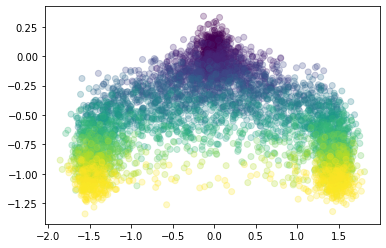

In [10]:
plt.scatter(sim_gt.x[:, 0], sim_gt.x[:, 1], alpha = 0.25, c = sim_gt.t_idx)

(-2.0, 2.0)

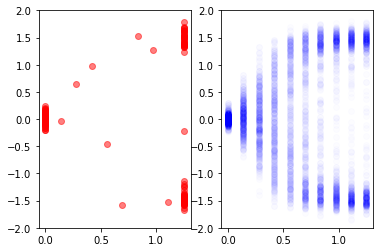

In [11]:
k = 0
plt.subplot(1, 2, 1)
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sims_all[-1].t_idx], sims_all[-1].x[:, k], alpha = 0.5, color = "red")
plt.ylim(-2.0, 2.0)
plt.subplot(1, 2, 2)
plt.scatter(np.linspace(0, model_sim.t_final, model_sim.T)[sim_gt.t_idx], sim_gt.x[:, k], alpha = 0.01, color = "blue")
plt.ylim(-2.0, 2.0)

In [12]:
importlib.reload(models)
importlib.reload(model_sim)
torch.set_num_threads(8)

In [13]:
models_all = [models.TrajLoss(torch.randn(model_sim.T, M, model_sim.dim)*0.1,
                        torch.tensor(s.x, device = device), 
                        torch.tensor(s.t_idx, device = device), 
                        dt = model_sim.t_final/model_sim.T, tau = model_sim.D, sigma = None, M = M,
                        lamda_reg = 0.05, lamda_cst = 0, sigma_cst = float("Inf"),
                        branching_rate_fn = model_sim.branching_rate,
                        sinkhorn_iters = 250, device = device, warm_start = True) for s in sims_all]

In [14]:
outputs_all = [models.optimize(m, n_iter = 2_500, eta_final = 0.1, tau_final = model_sim.D, sigma_final = 0.5, N = M, temp_init = 1.0, temp_ratio = 1.0, dim = model_sim.dim, tloss = m, print_interval = 50) for m in models_all]

Iteration 0, Loss = 2.372, Primal loss = 4.342, Avg. iters = 1.889, eta = 0.100, temp = 1.000
Iteration 50, Loss = 1.121, Primal loss = 2.574, Avg. iters = 22.000, eta = 0.100, temp = 1.000
Iteration 100, Loss = 0.952, Primal loss = 2.418, Avg. iters = 19.889, eta = 0.100, temp = 1.000
Iteration 150, Loss = 0.891, Primal loss = 2.353, Avg. iters = 19.889, eta = 0.100, temp = 1.000
Iteration 200, Loss = 0.842, Primal loss = 2.331, Avg. iters = 26.222, eta = 0.100, temp = 1.000
Iteration 250, Loss = 0.805, Primal loss = 2.323, Avg. iters = 19.333, eta = 0.100, temp = 1.000
Iteration 300, Loss = 0.786, Primal loss = 2.303, Avg. iters = 23.889, eta = 0.100, temp = 1.000
Iteration 350, Loss = 0.762, Primal loss = 2.304, Avg. iters = 18.000, eta = 0.100, temp = 1.000
Iteration 400, Loss = 0.768, Primal loss = 2.299, Avg. iters = 22.111, eta = 0.100, temp = 1.000
Iteration 450, Loss = 0.740, Primal loss = 2.293, Avg. iters = 12.222, eta = 0.100, temp = 1.000
Iteration 500, Loss = 0.745, Prima

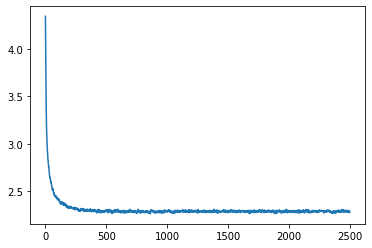

In [15]:
plt.plot(outputs_all[0][1])

Text(0.5, 1.0, 'Objective: primal')

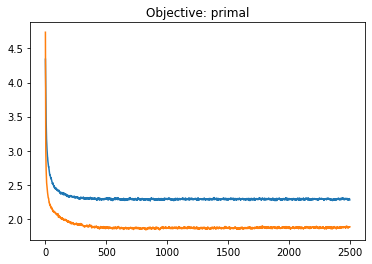

In [16]:
plt.plot(np.vstack([o[1] for o in outputs_all]).T)
plt.title("Objective: primal")

In [17]:
u = np.full(model_sim.dim, 1); u[2:] = 0
u = u/np.linalg.norm(u)

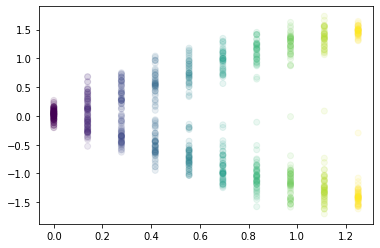

In [18]:
i = -1
with torch.no_grad():
    plt.scatter(np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), models_all[i].x.reshape(-1, model_sim.dim)[:, 0], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.1)
# plt.scatter(np.linspace(0, t_final, T)[simodel_sim.t_idx], np.dot(simodel_sim.x, u), alpha = 0.5, color = "red", marker = "x")

(-2.056414748032979,
 1.9339278596770721,
 -1.693109130794606,
 0.4107310508524957)

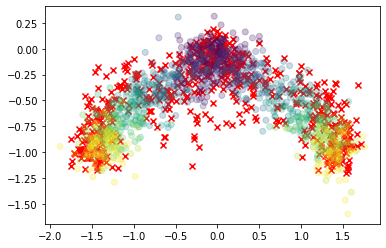

In [19]:
i = 0
plt.scatter(sims_all[i].x[:, 0], sims_all[i].x[:, 1], color = "red", marker = "x")
with torch.no_grad():
    plt.scatter(models_all[i].x.reshape(-1, model_sim.dim)[:, 0], models_all[i].x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25)
plt.axis('auto')

In [20]:
models_all_gwot = [gwot.models.OTModel(s, lamda_reg = 0.0025,
          eps_df = 0.01*torch.ones(s.T), 
          growth_constraint="exact", 
          pi_0 = "uniform",
          use_keops = False,
          device = device) for s in sims_all]

for m in models_all_gwot:
    m.solve_lbfgs(steps = 10, 
                    max_iter = 50, 
                    lr = 1,
                    history_size = 50, 
                    line_search_fn = 'strong_wolfe', 
                    factor = 2, 
                    tol = 1e-5, 
                    retry_max = 0);

/home/stephenz/base_env/lib/python3.8/site-packages/gwot/models.py:296: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  model.eps_df[i] * torch.exp(u/model.eps_df[i]).T @ (model.K_ij_df[i] @ torch.exp(v/model.eps_df[i]))


Iteration =  0  Dual obj =  -0.6775450542533741  Primal_obj =  61.86420850482249  Gap =  62.541753559075865 Sum =  68.46911524280489
Iteration =  1  Dual obj =  -0.027428658935094878  Primal_obj =  -0.027428183367289888  Gap =  4.755678049903067e-07 Sum =  0.9810323646178429
Iteration =  0  Dual obj =  -0.6261318437521719  Primal_obj =  57.03884142549414  Gap =  57.66497326924631 Sum =  66.33025356702522
Iteration =  1  Dual obj =  -0.016390483458482714  Primal_obj =  -0.008810529230121517  Gap =  0.007579954228361198 Sum =  0.9540081482182516
Iteration =  2  Dual obj =  -0.010073509344312294  Primal_obj =  -0.005789659152515739  Gap =  0.004283850191796555 Sum =  0.9763008421702785
Iteration =  3  Dual obj =  -0.0038223870516522936  Primal_obj =  0.0073068832066057795  Gap =  0.011129270258258073 Sum =  1.0111700984686167
Iteration =  4  Dual obj =  0.0023711644418688005  Primal_obj =  0.004226217024279701  Gap =  0.0018550525824109002 Sum =  0.9963425866276874
Iteration =  5  Dual ob

In [21]:
X_gwot_samples_all = [np.stack([m.ts.x[np.random.choice(m.ts.x.shape[0], size = M, p = torch.nn.functional.normalize(m.get_R(t).detach(), p = 1.0, dim = 0)), :] for t in range(model_sim.T)]) for m in models_all_gwot]

In [22]:
N_paths_gt = 250
N_paths = 50
paths_gt = sim_gt.sample_trajectory(steps_scale = int(model_sim.sim_steps/sim_gt.T), N = N_paths_gt)

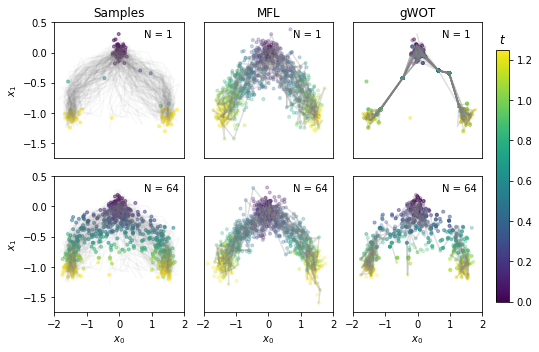

In [23]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (3*PLT_CELL, 2*PLT_CELL))
gs = GridSpec(2, 3, figure=fig)

for (i, s) in enumerate(sims_all):
    ax = fig.add_subplot(gs[len(models_all)-i-1, 0])
    # plt.scatter(np.linspace(0, t_final, T)[s.t_idx], np.dot(s.x, u), alpha = 0.25, color = "red", marker = ".")
    # plt.plot(np.linspace(0, t_final, paths_gt.shape[1]), np.dot(paths_gt, u).T, color = 'grey', alpha = 0.05);
    ax.plot(paths_gt[:, :, 0].T, paths_gt[:, :, 1].T, color = 'grey', alpha = 0.05);
    # ax.scatter(s.x[:, 0], s.x[:, 1], alpha = 0.5, color = "red", marker = ".")
    ax.scatter(s.x[:, 0], s.x[:, 1], alpha = 0.5, c = s.t_idx/s.T, marker = ".")
    ax.set_ylim(-1.75, 0.5); ax.set_xlim(-2, 2)
    ax.set_xlabel("$x_0$"); ax.set_ylabel("$x_1$")
    # ax.set_title("N = %d" % N_vals[i])
    ax.text(0.75, 0.25, "N = %d" % N_vals[i])
    if i > 0:
        ax.set_title("Samples")
        ax.get_xaxis().set_visible(False)

for (i, m) in enumerate(models_all):
    ax = fig.add_subplot(gs[len(models_all)-i-1, 1])
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = model_sim.T-1)
        # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
        ax.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
        # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(m.x.reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
        im = ax.scatter(m.x.reshape(-1, model_sim.dim)[:, 0], m.x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    ax.set_xlabel("$x_0$"); ax.set_ylabel("$x_1$")
    ax.set_ylim(-1.75, 0.5); ax.set_xlim(-2, 2)
    # ax.set_title("N = %d" % N_vals[i])
    ax.text(0.75, 0.25, "N = %d" % N_vals[i])
    ax.get_yaxis().set_visible(False)
    if i > 0:
        ax.set_title("MFL")
        ax.get_xaxis().set_visible(False)

for (i, x) in enumerate(X_gwot_samples_all):
    ax = fig.add_subplot(gs[len(models_all)-i-1, 2])
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = [sims_all[i].x, ]*sims_all[i].T, 
                                get_gamma_fn = lambda j : models_all_gwot[i].get_coupling_reg(j, K = models_all_gwot[i].get_K(j)), num_couplings = sims_all[i].T-1)
        # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
        ax.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
    # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(x, u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
    ax.scatter(x.reshape(-1, model_sim.dim)[:, 0], x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    ax.set_ylim(-1.75, 0.5); ax.set_xlim(-2, 2)
    ax.set_xlabel("$x_0$"); ax.set_ylabel("$x_1$")
    # ax.set_title("N = %d" % N_vals[i])
    ax.text(0.75, 0.25, "N = %d" % N_vals[i])
    ax.get_yaxis().set_visible(False)
    if i > 0:
        ax.set_title("gWOT")
        ax.get_xaxis().set_visible(False)

plt.tight_layout() 
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("$t$")
 
plt.savefig("fig1_langevin_new.pdf")

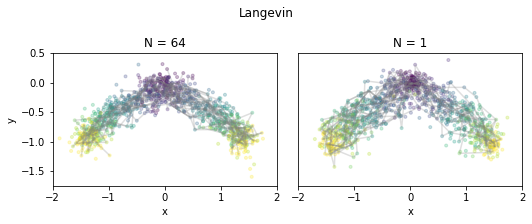

In [24]:
N_paths = 50
plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, m) in enumerate(models_all):
    plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = model_sim.T-1)
        # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
        plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
        # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(m.x.reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
        plt.scatter(m.x.reshape(-1, model_sim.dim)[:, 0], m.x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.xlabel("x"); plt.ylabel("y")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    plt.title("N = %d" % N_vals[i])
    if i > 0:
        plt.gca().get_yaxis().set_visible(False)
plt.suptitle("Langevin")
plt.tight_layout()
plt.savefig("fig1_langevin.pdf")

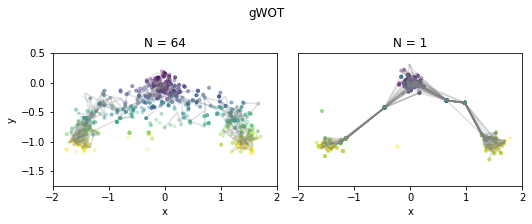

In [25]:
plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, x) in enumerate(X_gwot_samples_all):
    plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = [sims_all[i].x, ]*sims_all[i].T, 
                                get_gamma_fn = lambda j : models_all_gwot[i].get_coupling_reg(j, K = models_all_gwot[i].get_K(j)), num_couplings = sims_all[i].T-1)
        # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
        plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
    # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(x, u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.scatter(x.reshape(-1, model_sim.dim)[:, 0], x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    plt.xlabel("x"); plt.ylabel("y")
    if i > 0:
        plt.gca().get_yaxis().set_visible(False)
    plt.title("N = %d" % N_vals[i])
plt.suptitle("gWOT")
plt.tight_layout()
plt.savefig("fig1_gwot.pdf")

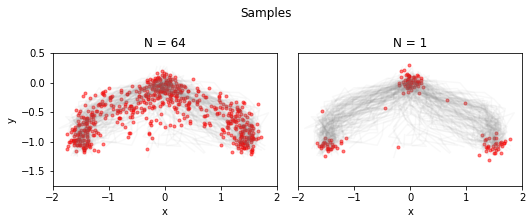

In [26]:
plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, s) in enumerate(sims_all):
    plt.subplot(1, len(N_vals), i+1)
    # plt.scatter(np.linspace(0, t_final, T)[s.t_idx], np.dot(s.x, u), alpha = 0.25, color = "red", marker = ".")
    # plt.plot(np.linspace(0, t_final, paths_gt.shape[1]), np.dot(paths_gt, u).T, color = 'grey', alpha = 0.05);
    plt.plot(paths_gt[:, :, 0].T, paths_gt[:, :, 1].T, color = 'grey', alpha = 0.05);
    plt.scatter(s.x[:, 0], s.x[:, 1], alpha = 0.5, color = "red", marker = ".")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    if i > 0:
        plt.gca().get_yaxis().set_visible(False)
    plt.xlabel("x"); plt.ylabel("y")
    plt.title("N = %d" % N_vals[i])
plt.suptitle("Samples")
plt.tight_layout()
plt.savefig("fig1_samples.pdf")

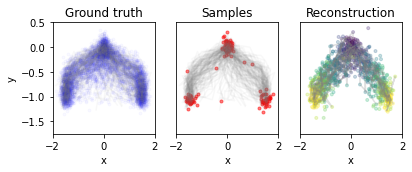

In [27]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
i = 1

plt.subplot(1, 4, 1)
plt.plot(paths_gt[:, :, 0].T, paths_gt[:, :, 1].T, color = 'grey', alpha = 0.05);
plt.scatter(sim_gt.x[:, 0], sim_gt.x[:, 1], alpha = 0.025, color = "blue", marker = ".")
plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Ground truth")

plt.subplot(1, 4, 2)
plt.plot(paths_gt[:, :, 0].T, paths_gt[:, :, 1].T, color = 'grey', alpha = 0.05);
plt.scatter(sims_all[i].x[:, 0], sims_all[i].x[:, 1], alpha = 0.5, color = "red", marker = ".")
plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
plt.xlabel("x")
plt.title("Samples")
plt.gca().get_yaxis().set_visible(False)

plt.subplot(1, 4, 3)
with torch.no_grad():
    paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                        get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = model_sim.T-1)
    # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
    plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
    # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(m.x.reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.scatter(m.x.reshape(-1, model_sim.dim)[:, 0], m.x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
plt.xlabel("x")
plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
plt.title("Reconstruction")
plt.gca().get_yaxis().set_visible(False)

plt.tight_layout()

# plt.subplot(1, 4, 4)
# with torch.no_grad():
#     paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = [sims_all[i].x, ]*sims_all[i].T, 
#                             get_gamma_fn = lambda j : models_all_gwot[i].get_coupling_reg(j, K = models_all_gwot[i].get_K(j)), num_couplings = sims_all[i].T-1)
#     # plt.plot(np.linspace(0, t_final, paths.shape[1]), np.dot(paths, u).T, color = 'grey', alpha = 0.1);
#     plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha = 0.25);
# # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(x, u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
# plt.scatter(x.reshape(-1, model_sim.dim)[:, 0], x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
# plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
# plt.gca().get_yaxis().set_visible(False)

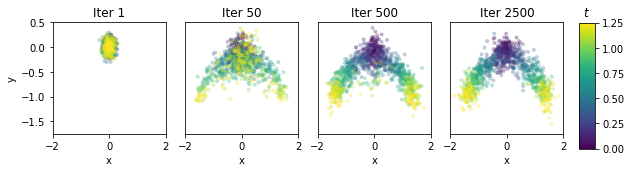

In [28]:
fig = plt.figure(figsize = (3.5*PLT_CELL, 1*PLT_CELL))
for (i, j) in enumerate(np.array([1, 50, 500, 2500])-1):
    plt.subplot(1, 4, i+1)
    # plt.scatter(np.kron(np.linspace(0, t_final, T), np.ones(M)), np.dot(outputs_all[0][2][j, :, :, :].reshape(-1, dim), u), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.1, marker = '.')
    im = plt.scatter(outputs_all[0][2][j, :, :, :].reshape(-1, model_sim.dim)[:, 0], outputs_all[0][2][j, :, :, :].reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    # plt.text(-1.75, -1.65, "Iter %d" % (j+1))
    plt.title("Iter %d" % (j+1))
    plt.xlabel("x")
    plt.ylabel("y")
    # if i // 4 == 0:
    #     plt.gca().get_xaxis().set_visible(False)
    if i % 4 > 0:
        plt.gca().get_yaxis().set_visible(False)
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("$t$")

plt.savefig("fig2_trainingdynamics.pdf")

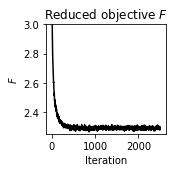

In [29]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
plt.plot(outputs_all[0][1], 'k')
plt.title("Reduced objective $F$")
plt.xlabel("Iteration")
plt.ylabel("$F$")
plt.tight_layout()
plt.ylim(2.25, 3.0)
plt.savefig("fig2_objective.pdf")